In [247]:
import numpy as numpy
import pandas as pd 


In [248]:
import os
os.path.abspath(os.getcwd())

'e:\\Alireza\\Uppsala\\Classes\\Data_Mining\\Project'

In [249]:
df = pd.read_csv("European_citiznes_rsvp_eu_clean.csv")
df.count()
df.dropna()

,COUNTRY,YEAR,SEX,circulatory_diseases,youth_unemployment_rate,gross_national_income,unemployment_rate,regular_daily_smokers,average_fruit_vegtable_ppd,fat_available_ppd,adult_overweight,self_injury,average_number_of_calories_available_per_person_per_day,total_hospital_beds,Ischaemic_heart_diseas,life_expectancy,alcahol_consumption_liter_per_capita,protein_ppd
0,Austria,1991.0,ALL,3051.58,3.72,21810.0,3.46,27.5,209.10,159.23,40.09,1.25,3556.0,70143.0,38.53,75.95,14.10,103.15
1,Austria,1992.0,ALL,3002.43,4.13,24520.0,3.61,35.0,212.51,161.42,40.40,1.44,3546.0,69268.0,37.38,76.13,13.60,103.95
2,Austria,1995.0,ALL,2844.85,5.91,28190.0,3.66,24.0,200.16,152.79,41.33,1.04,3510.0,67853.0,35.48,76.97,13.40,100.54
3,Austria,1999.0,ALL,2646.71,5.93,27080.0,3.72,36.3,205.56,157.23,42.58,0.83,3673.0,64594.0,30.69,78.13,12.80,105.49
4,Austria,2006.0,ALL,1834.76,9.75,41500.0,5.30,23.2,238.95,162.30,44.27,0.79,3719.0,63354.0,18.06,80.19,12.58,101.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Sweden,2010.0,ALL,1439.34,24.64,54630.0,8.60,13.6,150.66,129.79,49.31,0.98,3149.0,25566.0,14.54,81.76,7.38,108.49
251,Sweden,2011.0,ALL,1381.82,22.65,56700.0,7.80,13.1,152.10,132.29,49.44,0.75,3163.0,25566.0,13.84,81.99,7.31,107.76
252,Sweden,2012.0,ALL,1373.36,23.49,59090.0,8.00,12.8,154.73,134.35,49.56,0.67,3172.0,24927.0,12.56,81.90,7.23,105.86
253,Sweden,2013.0,ALL,1304.10,23.33,61800.0,8.00,10.7,153.04,130.49,49.65,0.81,3186.0,24905.0,12.69,82.11,7.32,108.84


In [250]:
import pandas as pd
import numpy as np

summary = {
    "n_rows": len(df),
    "n_countries": df["COUNTRY"].nunique(),
    "years_min": df["YEAR"].min(),
    "years_max": df["YEAR"].max(),
    "sex_levels": df["SEX"].unique().tolist(),
}
missing = df.isna().mean().sort_values(ascending=False)  # share missing per column

# 2) Per-country trend features (slopes and percent change)
def slope(y, x):
    if len(y.dropna()) < 3: return np.nan
    x = x.astype(float)
    y = y.astype(float)
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m

trend_cols = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
    "unemployment_rate",
    "gross_national_income",
    "youth_unemployment_rate",
    "Ischaemic_heart_diseas",
    "circulatory_diseases",
    "self_injury",
    "total_hospital_beds"
]

# Work on total (collapse SEX if you have both M/F): take average across SEX within country-year
df_tot = (df.groupby(["COUNTRY","YEAR"], as_index=False)
            [trend_cols].mean())

# Slopes per country
slopes = (df_tot
          .groupby("COUNTRY")
          .apply(lambda g: pd.Series({f"{c}_slope": slope(g[c], g["YEAR"]) for c in trend_cols}))
          .reset_index())

# Percent change 2002 -> 2022
def pct_change_2002_2022(g, col):
    g = g.sort_values("YEAR")
    first = g.loc[g["YEAR"].idxmin(), col] if not g.empty else np.nan
    last  = g.loc[g["YEAR"].idxmax(), col] if not g.empty else np.nan
    return (last - first) / first * 100 if pd.notna(first) and first != 0 else np.nan

pctchg = (df_tot
          .groupby("COUNTRY")
          .apply(lambda g: pd.Series({f"{c}_pctchg": pct_change_2002_2022(g, c) for c in trend_cols}))
          .reset_index())

trend_table = slopes.merge(pctchg, on="COUNTRY", how="outer")

# 3) Associations with life expectancy
# 3a) Overall Pearson correlations (latest year only, e.g., 2022)
latest_year = df_tot["YEAR"].max()
snap = df_tot[df_tot["YEAR"] == latest_year].copy()
corr_cols = ["life_expectancy","average_number_of_calories_available_per_person_per_day",
             "regular_daily_smokers","adult_overweight","alcahol_consumption_liter_per_capita",
             "fat_available_ppd","protein_ppd","average_fruit_vegtable_ppd","unemployment_rate","gross_national_income",
    "youth_unemployment_rate","Ischaemic_heart_diseas","circulatory_diseases","self_injury","total_hospital_beds"]
corr_latest = snap[corr_cols].corr().loc["life_expectancy"].sort_values(ascending=False)

# 3b) Within-country correlations (demeaned by country)
def demean_by_country(d, cols):
    return d.assign(**{c: d[c] - d.groupby("COUNTRY")[c].transform("mean") for c in cols})
dm = demean_by_country(df_tot, corr_cols)
corr_within = dm[corr_cols].corr().loc["life_expectancy"].sort_values(ascending=False)

# 4) Quick fixed-effects style regression (no external libs)
X_cols = ["average_number_of_calories_available_per_person_per_day",
          "regular_daily_smokers","alcahol_consumption_liter_per_capita",
          "unemployment_rate","gross_national_income","youth_unemployment_rate","Ischaemic_heart_diseas","circulatory_diseases","self_injury","total_hospital_beds"]
d = df_tot.dropna(subset=["life_expectancy"] + X_cols).copy()
# Add year dummies
year_dummies = pd.get_dummies(d["YEAR"], prefix="Y", drop_first=True)
X = pd.concat([d[X_cols], year_dummies], axis=1)
X = (X - X.mean())/X.std(ddof=0)  # scale for comparability
X["intercept"] = 1.0
y = d["life_expectancy"].astype(float)

# OLS via closed form
XtX = X.T @ X
Xty = X.T @ y
beta = np.linalg.pinv(XtX) @ Xty
coef = pd.Series(beta, index=X.columns).sort_values(ascending=False)

# 5) Country profiles (latest year z-scores)
Z = snap.copy()
for c in corr_cols:
    Z[c + "_z"] = (Z[c] - Z[c].mean()) / Z[c].std(ddof=0)
country_profile = Z[["COUNTRY"] + [c+"_z" for c in corr_cols]]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19924\1991574917.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{c}_slope": slope(g[c], g["YEAR"]) for c in trend_cols}))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19924\1991574917.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{c}_pctchg": pct_change_2002_2022(g, c) for c in trend_cols}))


In [251]:
missing

COUNTRY                                                    0.0
YEAR                                                       0.0
SEX                                                        0.0
circulatory_diseases                                       0.0
youth_unemployment_rate                                    0.0
gross_national_income                                      0.0
unemployment_rate                                          0.0
regular_daily_smokers                                      0.0
average_fruit_vegtable_ppd                                 0.0
fat_available_ppd                                          0.0
adult_overweight                                           0.0
self_injury                                                0.0
average_number_of_calories_available_per_person_per_day    0.0
total_hospital_beds                                        0.0
Ischaemic_heart_diseas                                     0.0
life_expectancy                                        

In [252]:
# import seaborn as sns
# sns.pairplot(df,hue="COUNTRY")

In [253]:
import numpy as np 
cols_to_bin = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "unemployment_rate",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
    "gross_national_income","youth_unemployment_rate",
    "Ischaemic_heart_diseas","circulatory_diseases",
    "self_injury","total_hospital_beds"   
]

for col in cols_to_bin:

    Q1 = np.percentile(df[f"{col}"], 25, interpolation = 'midpoint') 
    Q2 = np.percentile(df[f"{col}"], 50, interpolation = 'midpoint') 
    Q3 = np.percentile(df[f"{col}"], 75, interpolation = 'midpoint') 
    
    print('Q1 25 percentile of the given data is, ', Q1)
    print('Q1 50 percentile of the given data is, ', Q2)
    print('Q1 75 percentile of the given data is, ', Q3)

    IQR = Q3 - Q1 
    print('Interquartile range is', IQR)
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    print('low_limit is', low_lim)
    print('up_limit is', up_lim)
    outlier =[]
    for x in df[f"{col}"]:
        if ((x> up_lim) or (x<low_lim)):
            print(f"{col} had outlienr")
            outlier.append(x)

    print(' outlier in the dataset is', len(outlier))

Q1 25 percentile of the given data is,  76.065
Q1 50 percentile of the given data is,  78.35
Q1 75 percentile of the given data is,  80.185
Interquartile range is 4.1200000000000045
low_limit is 69.88499999999999
up_limit is 86.36500000000001
life_expectancy had outlienr
life_expectancy had outlienr
life_expectancy had outlienr
 outlier in the dataset is 3
Q1 25 percentile of the given data is,  3153.0
Q1 50 percentile of the given data is,  3313.0
Q1 75 percentile of the given data is,  3500.0
Interquartile range is 347.0
low_limit is 2632.5
up_limit is 4020.5
average_number_of_calories_available_per_person_per_day had outlienr
 outlier in the dataset is 1
Q1 25 percentile of the given data is,  5.95
Q1 50 percentile of the given data is,  7.8
Q1 75 percentile of the given data is,  10.7
Interquartile range is 4.749999999999999
low_limit is -1.174999999999998
up_limit is 17.824999999999996
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
une

In [254]:
from scipy import stats
stats.zscore(df["life_expectancy"]).min()

np.float64(-2.757887094850072)

In [255]:
data=df.copy()
data.COUNTRY.drop
df


,COUNTRY,YEAR,SEX,circulatory_diseases,youth_unemployment_rate,gross_national_income,unemployment_rate,regular_daily_smokers,average_fruit_vegtable_ppd,fat_available_ppd,adult_overweight,self_injury,average_number_of_calories_available_per_person_per_day,total_hospital_beds,Ischaemic_heart_diseas,life_expectancy,alcahol_consumption_liter_per_capita,protein_ppd
0,Austria,1991.0,ALL,3051.58,3.72,21810.0,3.46,27.5,209.10,159.23,40.09,1.25,3556.0,70143.0,38.53,75.95,14.10,103.15
1,Austria,1992.0,ALL,3002.43,4.13,24520.0,3.61,35.0,212.51,161.42,40.40,1.44,3546.0,69268.0,37.38,76.13,13.60,103.95
2,Austria,1995.0,ALL,2844.85,5.91,28190.0,3.66,24.0,200.16,152.79,41.33,1.04,3510.0,67853.0,35.48,76.97,13.40,100.54
3,Austria,1999.0,ALL,2646.71,5.93,27080.0,3.72,36.3,205.56,157.23,42.58,0.83,3673.0,64594.0,30.69,78.13,12.80,105.49
4,Austria,2006.0,ALL,1834.76,9.75,41500.0,5.30,23.2,238.95,162.30,44.27,0.79,3719.0,63354.0,18.06,80.19,12.58,101.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Sweden,2010.0,ALL,1439.34,24.64,54630.0,8.60,13.6,150.66,129.79,49.31,0.98,3149.0,25566.0,14.54,81.76,7.38,108.49
251,Sweden,2011.0,ALL,1381.82,22.65,56700.0,7.80,13.1,152.10,132.29,49.44,0.75,3163.0,25566.0,13.84,81.99,7.31,107.76
252,Sweden,2012.0,ALL,1373.36,23.49,59090.0,8.00,12.8,154.73,134.35,49.56,0.67,3172.0,24927.0,12.56,81.90,7.23,105.86
253,Sweden,2013.0,ALL,1304.10,23.33,61800.0,8.00,10.7,153.04,130.49,49.65,0.81,3186.0,24905.0,12.69,82.11,7.32,108.84


In [256]:
data . drop ([ 'COUNTRY'] , axis =1 , inplace = True )



In [257]:
import pandas as pd
import numpy as np


def tertile_labels(s):
    return pd.qcut(s.rank(method="first"), q=3, labels=["LOW","MID","HIGH"])

cols_to_bin = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "unemployment_rate",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",  
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
    "gross_national_income",
    "youth_unemployment_rate",
    "Ischaemic_heart_diseas",
    "circulatory_diseases",
    "self_injury",
    # "total_hospital_beds"
]

for c in cols_to_bin:
    df[c+"_bin"] = df.groupby("YEAR")[c].transform(tertile_labels)

# Build a string item for each binned column
rename_map = {
    "life_expectancy_bin": "LIFEEXP",
    "average_number_of_calories_available_per_person_per_day_bin": "CALORIES",
    "unemployment_rate_bin": "UNEMP",
    "regular_daily_smokers_bin": "SMOKING",
    "adult_overweight_bin": "OVERWT",
    "alcahol_consumption_liter_per_capita_bin": "ALCOHOL",
    "fat_available_ppd_bin": "FAT",
    "protein_ppd_bin": "PROTEIN",
    "average_fruit_vegtable_ppd_bin": "FRUITVEG",
    "gross_national_income_bin": "ANNUALINCOME",  
    "youth_unemployment_rate_bin": "YOUTH_UNEMP_RATE",  
    "Ischaemic_heart_diseas_bin": "HEARTDISEAS",  
    "circulatory_diseases_bin": "CIRCULATORYDISEAS",  
    "self_injury_bin": "SELFINJURY",  
    # "total_hospital_beds_bin": "TOTALHOSPBED"  
}

item_cols = [c+"_bin" for c in cols_to_bin]
print(item_cols)

def row_to_items(row):
    items = []
    for c in item_cols:
        label = str(row[c])
        var = rename_map[c]
        items.append(f"{var}={label}")
    return items

# 1 transaction = one (COUNTRY, YEAR)
tx_df = (df.sort_values(["COUNTRY","YEAR"])
           .dropna(subset=item_cols)
           .drop_duplicates(subset=["COUNTRY","YEAR"]))

transactions = tx_df.apply(row_to_items, axis=1).tolist()
num_records = len(transactions)
print("Transactions:", num_records)

['life_expectancy_bin', 'average_number_of_calories_available_per_person_per_day_bin', 'unemployment_rate_bin', 'regular_daily_smokers_bin', 'adult_overweight_bin', 'alcahol_consumption_liter_per_capita_bin', 'fat_available_ppd_bin', 'protein_ppd_bin', 'average_fruit_vegtable_ppd_bin', 'gross_national_income_bin', 'youth_unemployment_rate_bin', 'Ischaemic_heart_diseas_bin', 'circulatory_diseases_bin', 'self_injury_bin']
Transactions: 255


In [258]:
pd.DataFrame(transactions).to_csv("rules_stat.csv", index=False)
# clustered_labels = True

# if clustered_labels:
#     transactions = pd.read_csv("rules_stat_cluster_new.csv").values.tolist()
# else:
transactions = pd.read_csv("rules_stat.csv").values.tolist()

In [259]:
transactions

[['LIFEEXP=MID',
  'CALORIES=HIGH',
  'UNEMP=LOW',
  'SMOKING=MID',
  'OVERWT=MID',
  'ALCOHOL=HIGH',
  'FAT=HIGH',
  'PROTEIN=HIGH',
  'FRUITVEG=HIGH',
  'ANNUALINCOME=HIGH',
  'YOUTH_UNEMP_RATE=LOW',
  'HEARTDISEAS=HIGH',
  'CIRCULATORYDISEAS=HIGH',
  'SELFINJURY=HIGH'],
 ['LIFEEXP=MID',
  'CALORIES=HIGH',
  'UNEMP=LOW',
  'SMOKING=HIGH',
  'OVERWT=MID',
  'ALCOHOL=HIGH',
  'FAT=HIGH',
  'PROTEIN=HIGH',
  'FRUITVEG=HIGH',
  'ANNUALINCOME=MID',
  'YOUTH_UNEMP_RATE=LOW',
  'HEARTDISEAS=MID',
  'CIRCULATORYDISEAS=HIGH',
  'SELFINJURY=HIGH'],
 ['LIFEEXP=MID',
  'CALORIES=HIGH',
  'UNEMP=LOW',
  'SMOKING=LOW',
  'OVERWT=LOW',
  'ALCOHOL=HIGH',
  'FAT=HIGH',
  'PROTEIN=MID',
  'FRUITVEG=MID',
  'ANNUALINCOME=HIGH',
  'YOUTH_UNEMP_RATE=LOW',
  'HEARTDISEAS=HIGH',
  'CIRCULATORYDISEAS=HIGH',
  'SELFINJURY=MID'],
 ['LIFEEXP=HIGH',
  'CALORIES=HIGH',
  'UNEMP=LOW',
  'SMOKING=HIGH',
  'OVERWT=LOW',
  'ALCOHOL=HIGH',
  'FAT=HIGH',
  'PROTEIN=HIGH',
  'FRUITVEG=MID',
  'ANNUALINCOME=HIGH',
  'YO

In [260]:
import pyfpgrowth

# Choose minimum support as a COUNT like in your sheet:
# Example: require that an itemset appears in at least 20% of all (country,year) rows
min_support_frac = 0.10
sigma = max(1, int(np.floor(min_support_frac * num_records)))
print("Minimum support (count) =", sigma)

patterns = pyfpgrowth.find_frequent_patterns(transactions, sigma)
print("Frequent itemsets found:", len(patterns))

# Quick peek at biggest itemsets found

max_itemset_size=max(len(iset) for iset in patterns) 
print("Max frequent itemset size:", max_itemset_size)


Minimum support (count) = 25
Frequent itemsets found: 1457
Max frequent itemset size: 7


In [261]:
min_conf=0.4
raw_rules=pyfpgrowth.generate_association_rules(patterns, min_conf) 

In [262]:
raw_rules

{('LIFEEXP=MID', 'UNEMP=LOW'): (('YOUTH_UNEMP_RATE=LOW',), 0.9393939393939394),
 ('LIFEEXP=MID', 'YOUTH_UNEMP_RATE=LOW'): (('UNEMP=LOW',), 0.8157894736842105),
 ('UNEMP=LOW', 'YOUTH_UNEMP_RATE=LOW'): (('SELFINJURY=LOW',),
  0.4931506849315068),
 ('SMOKING=MID', 'UNEMP=LOW'): (('YOUTH_UNEMP_RATE=LOW',), 0.9333333333333333),
 ('SMOKING=MID', 'YOUTH_UNEMP_RATE=LOW'): (('UNEMP=LOW',), 0.8),
 ('FRUITVEG=HIGH', 'SMOKING=MID'): (('HEARTDISEAS=LOW',), 0.7878787878787878),
 ('CIRCULATORYDISEAS=LOW', 'HEARTDISEAS=LOW'): (('FAT=HIGH',),
  0.6714285714285714),
 ('CIRCULATORYDISEAS=LOW', 'SMOKING=MID'): (('HEARTDISEAS=LOW',), 0.875),
 ('CALORIES=HIGH', 'FAT=HIGH'): (('YOUTH_UNEMP_RATE=HIGH',), 0.453125),
 ('CALORIES=HIGH', 'SMOKING=MID'): (('FAT=HIGH',), 0.7222222222222222),
 ('FAT=HIGH', 'SMOKING=MID'): (('CALORIES=HIGH',), 0.7428571428571429),
 ('CIRCULATORYDISEAS=LOW', 'FAT=HIGH'): (('HEARTDISEAS=LOW',),
  0.7966101694915254),
 ('CIRCULATORYDISEAS=LOW', 'OVERWT=MID'): (('FAT=HIGH',), 0.892857142

In [263]:
from collections import Counter
import pandas as pd

rows = []
N = len(transactions)

for antecedent, (consequent, confidence) in raw_rules.items():
    # --- Normalize antecedent ---
    if isinstance(antecedent, (list, tuple, set, frozenset)):
        antecedent = {str(x) for x in antecedent}
    else:
        antecedent = {str(antecedent)}

    # --- Normalize consequent ---
    if isinstance(consequent, (list, tuple, set, frozenset)):
        consequent = {str(x) for x in consequent}
    else:
        consequent = {str(consequent)}

    union = antecedent | consequent

    # --- Support of union (antecedent+consequent) ---
    supp_union = sum(1 for basket in transactions if union.issubset(basket)) / N

    # --- Support of consequent ---
    supp_conseq = sum(1 for basket in transactions if consequent.issubset(basket)) / N

    # --- Lift ---
    lift = confidence / supp_conseq if supp_conseq > 0 else None
    print("confidence:",confidence)

    rows.append({
        "antecedent": tuple(sorted(antecedent)),
        "consequent": tuple(sorted(consequent)),
        "support": supp_union,
        "confidence": confidence,
        "lift": lift
    })

rules_df = pd.DataFrame(rows).sort_values(["lift","confidence","support"], ascending=False)


confidence: 0.9393939393939394
confidence: 0.8157894736842105
confidence: 0.4931506849315068
confidence: 0.9333333333333333
confidence: 0.8
confidence: 0.7878787878787878
confidence: 0.6714285714285714
confidence: 0.875
confidence: 0.453125
confidence: 0.7222222222222222
confidence: 0.7428571428571429
confidence: 0.7966101694915254
confidence: 0.8928571428571429
confidence: 0.8918918918918919
confidence: 0.896551724137931
confidence: 0.7027027027027027
confidence: 0.896551724137931
confidence: 0.8947368421052632
confidence: 0.8235294117647058
confidence: 0.8064516129032258
confidence: 0.9310344827586207
confidence: 0.9090909090909091
confidence: 0.9615384615384616
confidence: 1.0
confidence: 1.0
confidence: 1.0
confidence: 0.9272727272727272
confidence: 0.6086956521739131
confidence: 1.0
confidence: 0.9245283018867925
confidence: 0.9285714285714286
confidence: 0.9615384615384616
confidence: 0.9354838709677419
confidence: 0.9272727272727272
confidence: 0.9285714285714286
confidence: 0.9

In [264]:
rules_df 

,antecedent,consequent,support,confidence,lift
207,"(ANNUALINCOME=HIGH, CALORIES=LOW)","(ALCOHOL=LOW, LIFEEXP=HIGH, OVERWT=LOW)",0.109804,0.933333,6.102564
208,"(ANNUALINCOME=HIGH, CALORIES=LOW, LIFEEXP=HIGH)","(ALCOHOL=LOW, OVERWT=LOW)",0.109804,1.000000,5.795455
827,"(ANNUALINCOME=LOW, CIRCULATORYDISEAS=HIGH, HEA...","(LIFEEXP=LOW, UNEMP=HIGH)",0.101961,0.962963,5.710594
820,"(ANNUALINCOME=LOW, CIRCULATORYDISEAS=HIGH, YOU...","(HEARTDISEAS=HIGH, LIFEEXP=LOW, UNEMP=HIGH)",0.101961,0.928571,5.506645
343,"(LIFEEXP=LOW, PROTEIN=LOW, YOUTH_UNEMP_RATE=HIGH)","(CIRCULATORYDISEAS=HIGH, HEARTDISEAS=HIGH, UNE...",0.098039,0.961538,5.216858
...,...,...,...,...,...
54,"(FRUITVEG=HIGH, LIFEEXP=HIGH)","(YOUTH_UNEMP_RATE=HIGH,)",0.113725,0.491525,1.347731
73,"(ANNUALINCOME=HIGH, LIFEEXP=HIGH)","(FAT=HIGH,)",0.098039,0.471698,1.293366
8,"(CALORIES=HIGH, FAT=HIGH)","(YOUTH_UNEMP_RATE=HIGH,)",0.113725,0.453125,1.242440
236,"(CALORIES=HIGH, PROTEIN=HIGH)","(YOUTH_UNEMP_RATE=HIGH,)",0.098039,0.431034,1.181869


In [265]:
print(rules_df["antecedent"][37])

('CIRCULATORYDISEAS=HIGH', 'HEARTDISEAS=HIGH', 'LIFEEXP=LOW', 'OVERWT=MID')


In [266]:
rules_df["support"].max()

np.float64(0.27450980392156865)

In [267]:
rules_df["lift"]

207    6.102564
208    5.795455
827    5.710594
820    5.506645
343    5.216858
         ...   
54     1.347731
73     1.293366
8      1.242440
236    1.181869
110    1.120361
Name: lift, Length: 1031, dtype: float64

In [268]:
df_filtered = rules_df[rules_df["confidence"]>0.7]
df_filtered.head(15)


,antecedent,consequent,support,confidence,lift
207,"(ANNUALINCOME=HIGH, CALORIES=LOW)","(ALCOHOL=LOW, LIFEEXP=HIGH, OVERWT=LOW)",0.109804,0.933333,6.102564
208,"(ANNUALINCOME=HIGH, CALORIES=LOW, LIFEEXP=HIGH)","(ALCOHOL=LOW, OVERWT=LOW)",0.109804,1.000000,5.795455
827,"(ANNUALINCOME=LOW, CIRCULATORYDISEAS=HIGH, HEA...","(LIFEEXP=LOW, UNEMP=HIGH)",0.101961,0.962963,5.710594
820,"(ANNUALINCOME=LOW, CIRCULATORYDISEAS=HIGH, YOU...","(HEARTDISEAS=HIGH, LIFEEXP=LOW, UNEMP=HIGH)",0.101961,0.928571,5.506645
343,"(LIFEEXP=LOW, PROTEIN=LOW, YOUTH_UNEMP_RATE=HIGH)","(CIRCULATORYDISEAS=HIGH, HEARTDISEAS=HIGH, UNE...",0.098039,0.961538,5.216858
209,"(ANNUALINCOME=HIGH, CALORIES=LOW, OVERWT=LOW)","(ALCOHOL=LOW, LIFEEXP=HIGH)",0.109804,1.000000,5.204082
357,"(HEARTDISEAS=HIGH, LIFEEXP=LOW, PROTEIN=LOW, Y...","(CIRCULATORYDISEAS=HIGH, UNEMP=HIGH)",0.098039,0.961538,5.003925
342,"(CIRCULATORYDISEAS=HIGH, LIFEEXP=LOW, YOUTH_UN...","(ANNUALINCOME=LOW, HEARTDISEAS=HIGH, UNEMP=HIGH)",0.101961,0.812500,4.933036
559,"(HEARTDISEAS=HIGH, LIFEEXP=LOW, SELFINJURY=HIG...","(CIRCULATORYDISEAS=HIGH, UNEMP=HIGH)",0.101961,0.928571,4.832362
672,"(CALORIES=LOW, CIRCULATORYDISEAS=HIGH, FRUITVE...","(HEARTDISEAS=HIGH, LIFEEXP=LOW, PROTEIN=LOW)",0.098039,1.000000,4.811321


In [293]:
df_filtered["consequent"][725]

('CIRCULATORYDISEAS=HIGH', 'LIFEEXP=LOW', 'PROTEIN=LOW')

In [269]:
df.columns

Index(['COUNTRY', 'YEAR', 'SEX', 'circulatory_diseases',
       'youth_unemployment_rate', 'gross_national_income', 'unemployment_rate',
       'regular_daily_smokers', 'average_fruit_vegtable_ppd',
       'fat_available_ppd', 'adult_overweight', 'self_injury',
       'average_number_of_calories_available_per_person_per_day',
       'total_hospital_beds', 'Ischaemic_heart_diseas', 'life_expectancy',
       'alcahol_consumption_liter_per_capita', 'protein_ppd',
       'life_expectancy_bin',
       'average_number_of_calories_available_per_person_per_day_bin',
       'unemployment_rate_bin', 'regular_daily_smokers_bin',
       'adult_overweight_bin', 'alcahol_consumption_liter_per_capita_bin',
       'fat_available_ppd_bin', 'protein_ppd_bin',
       'average_fruit_vegtable_ppd_bin', 'gross_national_income_bin',
       'youth_unemployment_rate_bin', 'Ischaemic_heart_diseas_bin',
       'circulatory_diseases_bin', 'self_injury_bin'],
      dtype='object')

In [294]:
df_ax=df[(df["gross_national_income_bin"]=="LOW")& (df["average_number_of_calories_available_per_person_per_day_bin"]=="LOW") & (df["Ischaemic_heart_diseas_bin"]=="HIGH")]
countries_rule_1=df_ax["COUNTRY"].unique()
countries_rule_1

array(['Bulgaria', 'Czechia', 'Estonia', 'Croatia', 'Hungary', 'Latvia', 'Romania', 'Slovakia', 'Slovenia'], dtype=object)

In [295]:
df_ax

,COUNTRY,YEAR,SEX,circulatory_diseases,youth_unemployment_rate,gross_national_income,unemployment_rate,regular_daily_smokers,average_fruit_vegtable_ppd,fat_available_ppd,...,adult_overweight_bin,alcahol_consumption_liter_per_capita_bin,fat_available_ppd_bin,protein_ppd_bin,average_fruit_vegtable_ppd_bin,gross_national_income_bin,youth_unemployment_rate_bin,Ischaemic_heart_diseas_bin,circulatory_diseases_bin,self_injury_bin
16,Bulgaria,2001.0,ALL,5035.02,39.07,1770.0,17.3,32.7,166.25,92.23,...,MID,MID,LOW,LOW,LOW,LOW,HIGH,HIGH,HIGH,HIGH
17,Bulgaria,2007.0,ALL,4629.05,15.17,4820.0,6.9,39.7,125.08,93.82,...,LOW,MID,LOW,LOW,LOW,LOW,MID,HIGH,HIGH,HIGH
18,Bulgaria,2008.0,ALL,4399.22,12.79,6070.0,5.6,29.2,112.13,92.48,...,LOW,MID,LOW,LOW,LOW,LOW,MID,HIGH,HIGH,HIGH
19,Bulgaria,2014.0,ALL,3999.37,23.77,7700.0,11.4,28.2,109.15,88.16,...,LOW,MID,LOW,LOW,LOW,LOW,MID,HIGH,HIGH,HIGH
23,Czechia,1999.0,ALL,3681.60,16.50,6110.0,8.7,23.5,155.84,113.97,...,HIGH,HIGH,LOW,LOW,LOW,LOW,MID,HIGH,HIGH,HIGH
27,Czechia,2005.0,ALL,3235.22,19.26,12480.0,7.9,24.3,148.71,128.05,...,HIGH,HIGH,MID,LOW,LOW,LOW,MID,HIGH,HIGH,LOW
33,Czechia,2011.0,ALL,2528.11,18.02,19460.0,6.7,21.7,123.47,133.25,...,HIGH,HIGH,MID,LOW,LOW,LOW,LOW,HIGH,HIGH,MID
35,Czechia,2013.0,ALL,2375.89,18.95,19410.0,7.0,22.2,119.87,137.05,...,HIGH,HIGH,MID,LOW,LOW,LOW,MID,HIGH,HIGH,MID
71,Estonia,2000.0,ALL,3851.18,21.11,4170.0,14.6,30.3,152.32,86.54,...,MID,MID,LOW,LOW,LOW,LOW,MID,HIGH,HIGH,HIGH
72,Estonia,2002.0,ALL,3812.55,20.20,4620.0,11.2,28.3,149.93,99.06,...,MID,HIGH,LOW,LOW,LOW,LOW,HIGH,HIGH,HIGH,HIGH


COUNTRY
Latvia      9
Bulgaria    4
Czechia     4
Slovakia    4
Estonia     4
Hungary     3
Croatia     2
Romania     2
Slovenia    1
Name: count, dtype: int64


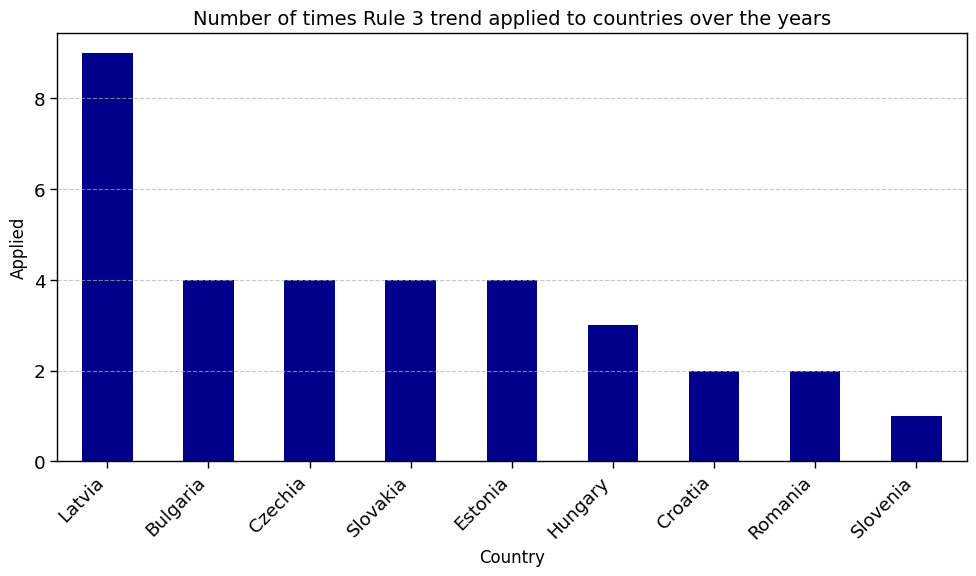

In [297]:
import matplotlib.pyplot as plt

country_counts = df_ax['COUNTRY'].value_counts()
print(country_counts)


plt.figure(figsize=(10, 6))

country_counts.plot(kind='bar', color='darkblue')


plt.title(
    'Number of times Rule 3 trend applied to countries over the years',
    fontsize=14
)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Applied', fontsize=12)


plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()

plt.savefig('filtered_countries_frequency1.png')

In [273]:
df_ax_2=df[(df["fat_available_ppd_bin"]=="HIGH")] 
countries_rule_2=df_ax_2["COUNTRY"].unique()
countries_rule_2

array(['Austria', 'Belgium', 'Czechia', 'Germany', 'Denmark', 'Spain', 'Finland', 'France', 'Greece', 'Hungary', 'Ireland',
       'Italy', 'Luxembourg', 'Netherlands'], dtype=object)

In [274]:
df_countries_rule1=df[df["protein_ppd_bin"]=="LOW"]
rule1_df_ct=df_countries_rule1["COUNTRY"].unique()
rule1_df_ct

array(['Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Finland', 'Croatia', 'Hungary', 'Latvia',
       'Netherlands', 'Poland', 'Romania', 'Slovakia', 'Slovenia', 'Sweden'], dtype=object)

In [287]:
df_ax_2

,COUNTRY,YEAR,SEX,circulatory_diseases,youth_unemployment_rate,gross_national_income,unemployment_rate,regular_daily_smokers,average_fruit_vegtable_ppd,fat_available_ppd,...,adult_overweight_bin,alcahol_consumption_liter_per_capita_bin,fat_available_ppd_bin,protein_ppd_bin,average_fruit_vegtable_ppd_bin,gross_national_income_bin,youth_unemployment_rate_bin,Ischaemic_heart_diseas_bin,circulatory_diseases_bin,self_injury_bin
0,Austria,1991.0,ALL,3051.58,3.72,21810.0,3.46,27.50,209.10,159.23,...,MID,HIGH,HIGH,HIGH,HIGH,HIGH,LOW,HIGH,HIGH,HIGH
1,Austria,1992.0,ALL,3002.43,4.13,24520.0,3.61,35.00,212.51,161.42,...,MID,HIGH,HIGH,HIGH,HIGH,MID,LOW,MID,HIGH,HIGH
2,Austria,1995.0,ALL,2844.85,5.91,28190.0,3.66,24.00,200.16,152.79,...,LOW,HIGH,HIGH,MID,MID,HIGH,LOW,HIGH,HIGH,MID
3,Austria,1999.0,ALL,2646.71,5.93,27080.0,3.72,36.30,205.56,157.23,...,LOW,HIGH,HIGH,HIGH,MID,HIGH,LOW,HIGH,HIGH,LOW
4,Austria,2006.0,ALL,1834.76,9.75,41500.0,5.30,23.20,238.95,162.30,...,LOW,HIGH,HIGH,MID,HIGH,MID,LOW,MID,MID,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Netherlands,2000.0,ALL,1751.15,5.27,28840.0,2.90,32.40,219.03,146.17,...,MID,MID,HIGH,HIGH,HIGH,HIGH,LOW,MID,LOW,LOW
195,Netherlands,2002.0,ALL,1657.23,4.58,27090.0,3.10,27.62,229.92,143.95,...,LOW,MID,HIGH,MID,HIGH,HIGH,LOW,LOW,LOW,MID
197,Netherlands,2004.0,ALL,1498.06,8.02,37390.0,6.80,25.38,224.26,133.44,...,LOW,LOW,HIGH,MID,HIGH,HIGH,LOW,LOW,LOW,MID
198,Netherlands,2005.0,ALL,1421.33,11.87,42110.0,7.00,25.21,213.11,140.09,...,LOW,LOW,HIGH,MID,MID,HIGH,LOW,LOW,LOW,MID


COUNTRY
Italy          19
Netherlands    13
Luxembourg     12
Belgium        10
Spain           7
Austria         6
France          6
Ireland         5
Czechia         4
Germany         4
Finland         2
Hungary         2
Greece          2
Denmark         1
Name: count, dtype: int64


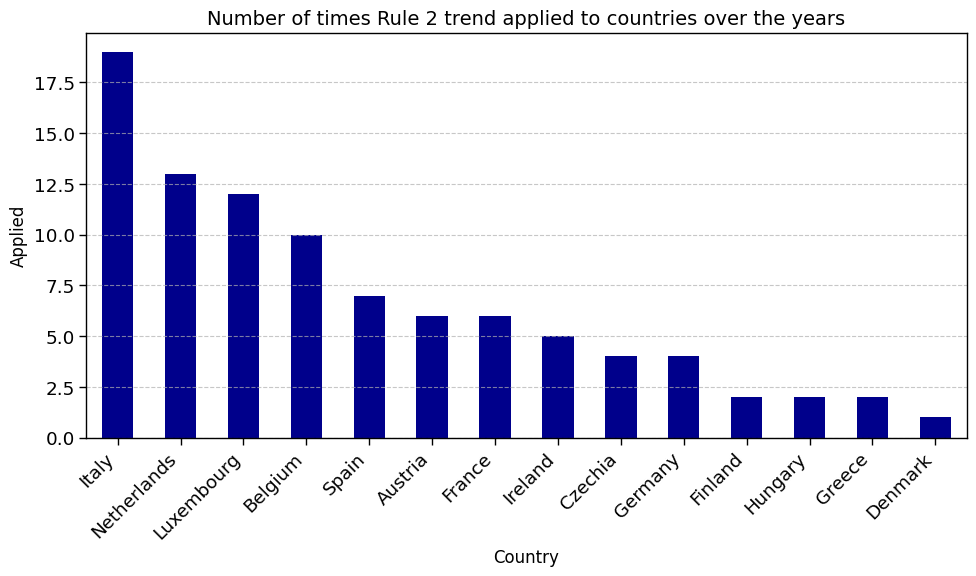

In [276]:
import matplotlib.pyplot as plt

country_counts = df_ax_2['COUNTRY'].value_counts()
print(country_counts)


plt.figure(figsize=(10, 6))

country_counts.plot(kind='bar', color='darkblue')


plt.title(
    'Number of times Rule 2 trend applied to countries over the years',
    fontsize=14
)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Applied', fontsize=12)


plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()

plt.savefig('filtered_countries_frequency.png')

In [277]:
#COUNTRIES WITH HIGH circulatory diseases 
high_circulatory_dis_countries=df[df["circulatory_diseases_bin"]=="HIGH"]
high_circulatory_dis_countries["COUNTRY"].unique()


array(['Austria', 'Bulgaria', 'Czechia', 'Germany', 'Estonia', 'Finland', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Lithuania',
       'Luxembourg', 'Latvia', 'Malta', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden'], dtype=object)

In [278]:
print(len(high_circulatory_dis_countries["COUNTRY"].unique()))

20


In [279]:
data . drop ([ 'SEX'] , axis =1 , inplace = True )

In [280]:
df.columns

Index(['COUNTRY', 'YEAR', 'SEX', 'circulatory_diseases',
       'youth_unemployment_rate', 'gross_national_income', 'unemployment_rate',
       'regular_daily_smokers', 'average_fruit_vegtable_ppd',
       'fat_available_ppd', 'adult_overweight', 'self_injury',
       'average_number_of_calories_available_per_person_per_day',
       'total_hospital_beds', 'Ischaemic_heart_diseas', 'life_expectancy',
       'alcahol_consumption_liter_per_capita', 'protein_ppd',
       'life_expectancy_bin',
       'average_number_of_calories_available_per_person_per_day_bin',
       'unemployment_rate_bin', 'regular_daily_smokers_bin',
       'adult_overweight_bin', 'alcahol_consumption_liter_per_capita_bin',
       'fat_available_ppd_bin', 'protein_ppd_bin',
       'average_fruit_vegtable_ppd_bin', 'gross_national_income_bin',
       'youth_unemployment_rate_bin', 'Ischaemic_heart_diseas_bin',
       'circulatory_diseases_bin', 'self_injury_bin'],
      dtype='object')

In [281]:
from sklearn . preprocessing import MinMaxScaler
minmax_scaled = MinMaxScaler().fit_transform (data)

In [282]:
from sklearn . decomposition import PCA
pca = PCA ()
principal_component=pca.fit_transform(data)

In [283]:
print(pca.explained_variance_ratio_)

[9.83107595e-01 1.68720186e-02 1.84299487e-05 1.83821328e-06 9.68643304e-08 7.21931755e-09 4.62580422e-09 4.09517151e-09
 2.06190587e-09 1.30216509e-09 6.84695217e-10 6.11131252e-10 1.45587048e-10 1.10753565e-10 5.49694816e-11 2.31672650e-11]


In [284]:
principal_component

array([[-2.66541415e+04, -7.40760441e+03,  4.64754481e+02, ...,  1.06179319e+00, -6.30302252e-03,  9.02872889e-01],
       [-2.75582835e+04, -4.70738207e+03,  5.22591955e+02, ...,  4.71096892e-01,  1.55561168e-02,  1.16462917e+00],
       [-2.90126887e+04, -1.04964632e+03,  5.13561696e+02, ...,  1.02799475e+00, -4.39404164e-01,  9.36332896e-01],
       ...,
       [-7.22685668e+04,  2.94193824e+04,  2.60238379e+02, ...,  5.83216802e-01,  3.62590744e-01, -1.88324185e-01],
       [-7.23197354e+04,  3.21296561e+04,  2.96636926e+02, ...,  7.66390591e-01,  2.89386036e-01, -1.60678781e-01],
       [-7.26224328e+04,  3.21984588e+04,  2.45542177e+02, ...,  1.07233211e+00,  4.19467200e-01,  2.34445920e-02]])

Mean: 3306.5254901960784
Variance: 53411.96699730872
Standard Deviation: 231.1102918463579


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19924\3712869183.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(X, shade=True)


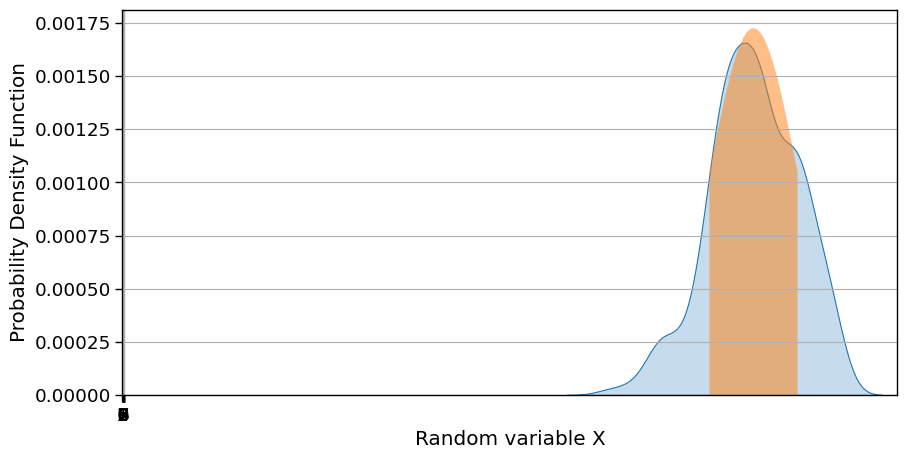

In [285]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

# Line width: Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)
sns.set_context("paper", font_scale=1.5)

# Distribution
X=df["average_number_of_calories_available_per_person_per_day"]
mean = np.mean(X)
var = np.var(X)
std = np.std(X)

print("Mean:", mean)
print("Variance:", var)
print("Standard Deviation:", std)


plt.figure(figsize=(10, 5))

ax = sns.kdeplot(X, shade=True)

# Plot 1-std
x = np.linspace(mean - std, mean + std)
y = norm.pdf(x, mean, std)
ax.fill_between(x, y, alpha=0.5)

plt.xlabel("Random variable X")
plt.ylabel("Probability Density Function")
plt.xticks(ticks=range(0, 10))
plt.grid()

plt.show()